In [23]:
%pip install gurobipy
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [24]:
rnd = np.random
rnd.seed(51)

In [25]:
n = 6  # number of clients
f = 3  # number of charging stations
num_points = n + f + 1

# Generate random coordinates for xc and yc
xc = np.random.rand(num_points) * 200
yc = np.random.rand(num_points) * 100

# Randomly select f points from the generated points
selected_indices = np.random.choice(num_points, f, replace=False)
selected_xc = xc[selected_indices]
selected_yc = yc[selected_indices]

# Remove the selected points from xc and yc
xc = np.delete(xc, selected_indices)
yc = np.delete(yc, selected_indices)
xc=np.append(xc,xc[0])
yc=np.append(yc,yc[0])

# print(xc)
# print(yc)
num_of_copies = 2
# Append copies of each selected point after the first n points
for i in range(f):
    for _ in range(num_of_copies):
        xc = np.append(xc, selected_xc[i])
        yc = np.append(yc, selected_yc[i])
# print("Remaining xc:", xc)
# print("Remaining yc:", yc)

14


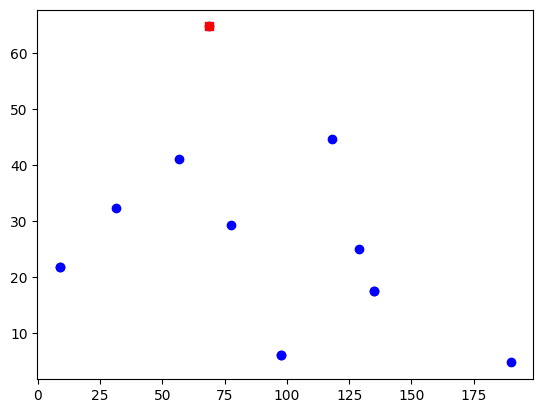

In [26]:
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')
print(len(xc))

In [27]:
I = [i for i in range(1, n+1)] #Number of nodes/locations
F = [i for i in range(n+2,n+2+num_of_copies*f)]
N = I + F
F_depo = [0] + F
I_depo = [0] + N
I_dest = N + [n+1]
I_depo_dest = N + [0] + [n+1]
# print(I_dest)
num_of_vehicles = 5
K = [i for i in range(1,num_of_vehicles+1)]
A = [(i, j, k) for i in I_depo for j in I_dest for k in K if i != j] 
dist = [(i, j) for i in I_depo for j in I_dest if i != j] 
total_with_vehicles = [(i,k) for i in I_depo_dest for k in K]
# print("aman")
# print(K)
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in dist} 

lb = 14
ub = 20
C = {k: rnd.randint(lb, ub) for k in K}

S = 0.2  
thresholds = [50, 100, 150, 200]
multipliers = [1.0, 1.19, 1.29, 1.39, 1.49]
velocities = [20,30,40,50]
ranges=4
t = {}

for i, j, k in A:
    avg_value = c[i,j]
    if(c[i,j]<thresholds[0]):
        for k in K:
                t[i, j, k] = C[k] *S* multipliers[0]*c[i,j]
    elif(c[i,j]<=200):
         for x in range(0,ranges-1):
              if(c[i,j]>=thresholds[x] and c[i,j]<=thresholds[x+1]):
                           for k in K:
                               t[i, j, k] = C[k] *S* multipliers[x+1]*c[i,j]
    else:
         for k in K:
                t[i, j, k] = C[k] *S* multipliers[ranges-1]*c[i,j]

time_variables = [(i,k) for i in F for k in K]
q = {i: rnd.randint(1, 10) for i in N}
# for _ in range()
Q = 500
H = 50 
max_value = max(c.values())
Q = H*1.1*max_value
q[0]=0
R = 2000 #per hour
for i in range(n+1,n+2+num_of_copies*f):
    q[i] = 0
Q=10000
max_dist_limit = 290
max_time_limit = 1000

In [28]:
from gurobipy import Model, GRB, quicksum

model = Model('ECVRP')
x = model.addVars(A, vtype=GRB.BINARY, name='x')
u = model.addVars(total_with_vehicles, vtype=GRB.CONTINUOUS,lb=0.0, name='u')
y = model.addVars(total_with_vehicles, vtype=GRB.CONTINUOUS,lb=0.0, ub=Q, name='y')
h = model.addVars(total_with_vehicles, vtype=GRB.CONTINUOUS, name='h')
time = model.addVars(A,vtype=GRB.CONTINUOUS, lb=0.0, name='t')

for i,k in u.keys():
    u[i,k].ub = C[k]
    u[i,k].lb = 0


model.modelSense = GRB.MINIMIZE
# u[0].setAttr(GRB.Attr.LB, C)
# u[0].setAttr(GRB.Attr.UB, C)
# y[0].setAttr(GRB.Attr.LB, Q)
# y[0].setAttr(GRB.Attr.UB, Q)
model.setObjective(quicksum(x[i, j, k]*(c[i, j]+time[i,j,k]) for i, j, k in A) + quicksum(x[i,j,k]*(Q/R) for i in I_depo for j in F if i!=j for k in K))
model.addConstrs((quicksum(x[i, j, k] for k in K for j in I_dest if i!=j) == 1 for i in I), name='outgoing')
model.addConstrs((quicksum(x[i, j, k] for k in K for j in I_dest if i!=j) <= 1 for i in F), name='charging_outgoing')
model.addConstrs((quicksum(x[0, j, k] for j in N) <= 1 for k in K), name='charging_outgoing')
model.addConstrs((quicksum(x[i, j, k] for i in I_depo if i!=j)-quicksum(x[j,i,k] for i in I_dest if i!=j) == 0 for j in N for k in K), name='blockage')
model.addConstrs((u[j,k]<=u[i,k]-q[i]*x[i,j,k]+ C[k]*(1-x[i,j,k]) for i in I_depo for j in I_dest if i!=j for k in K), name='weight_transfer')
model.addConstrs(quicksum(x[i,j,k]*c[i,j] for i in I_depo for j in I_dest if i!=j)<=max_dist_limit for k in K)
model.addConstrs((quicksum(x[i,j,k]*t[i,j,k] for i in I_depo for j in I_dest if i!=j) + quicksum(x[i,j,k]*(Q/R) for i in I_depo for j in F if i!=j))<=max_time_limit for k in K)

# model.addConstrs((u[i]>=0 for i in I_dest), name='weight_lower_bound')
# model.addConstrs((u[0]<=C), name='weight_upper_bound')

Temp = 323
theta = 0.1
H = H*0.8 + Temp*(theta)
model.addConstrs(h[i,k] == H + u[i,k] / C[k] for i in I_depo_dest for k in K)
model.addConstrs(time[i,j,k] == t[i,j,k]*u[i,k] for i in I_depo for j in I_dest if i!=j for k in K)
model.addConstrs((y[j,k]<=y[i,k]-h[i,k]*c[i,j]*x[i,j,k]+Q*(1-x[i,j,k]) for i in I for j in  I_dest  if i!=j for k in K), name = 'charge_left')
model.addConstrs((y[j,k]<=Q-h[i,k]*c[i,j]*x[i,j,k] for i in F_depo for j in I_dest  if i!=j for k in K), name='after leaving from charging station')
# model.addConstrs((y[i]>=0 for i in I_dest), name='charge_lower_bound')
# model.addConstrs((y[i]<=Q for i in N), name='charge_upper_bound')
# model.addConstr(u[0]==C, name='Specifying_constant_weight')
model.addConstrs((u[0,k]==C[k] for k in K), name='Specifying_constant_weight')
model.addConstrs((y[0,k]==Q for k in K), name='Specifying_constant_charge')
model.Params.MIPGap = 0.1
model.Params.TimeLimit = 50  # seconds
model.optimize()
# optimal path -  active paths


Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 50
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6500U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1737 rows, 1780 columns and 7790 nonzeros
Model fingerprint: 0x0b7897c5
Model has 785 quadratic objective terms
Model has 785 quadratic constraints
Variable types: 995 continuous, 785 integer (785 binary)
Coefficient statistics:
  Matrix range     [5e-02, 1e+03]
  QMatrix range    [1e+01, 2e+02]
  QLMatrix range   [1e+00, 1e+04]
  Objective range  [5e+00, 2e+02]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 1e+04]
  QRHS range       [1e+04, 1e+04]
Presolve removed 298 rows and 273 columns
Presolve time: 0.09s
Presolved: 3377 rows, 2799 columns, 16260 nonzeros
Variable types: 2028 continuous, 771 integer (736 binary)

Root relaxatio

In [29]:
# model.computeIIS()
model.write("model10.lp")

In [30]:
# for var_name in u:
#     u_var = u[var_name]
#     print(f"{var_name} = {u_var.X}")

In [31]:
# for var_name in h:
#     h_var = h[var_name]
#     print(f"{var_name} = {h_var.X}")

In [32]:
# for var_name in y:
#     y_var = y[var_name]
#     print(f"{var_name} = {y_var.X}")

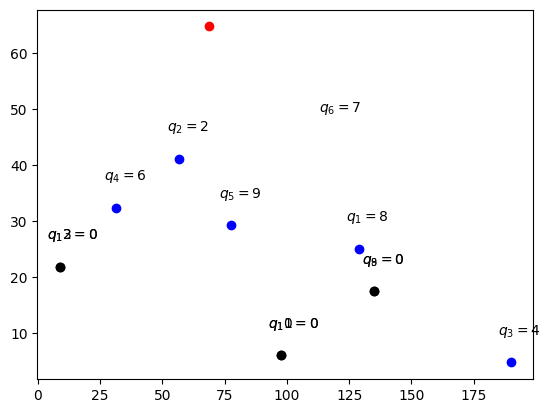

In [33]:
active_arcs = [a for a in A if x[a].x > 0.99]

# print(active_arcs)
plt.scatter(xc[1:n], yc[1:n], c = 'b')
plt.scatter(xc[n+2:],yc[n+2:], c= 'black')
plt.scatter(xc[0], yc[0], c='r')

# plt.title('Optimal route with %s as max weight'%C, fontsize = 20)
for i in I_depo_dest:
    plt.annotate('$q_%d = %d$' % (i,q[i]), (xc[i]-5, yc[i]+5))
    # plt.annotate('$q_%d = %d$' % (i,y[i]), (xc[i]-5, yc[i]+5))
# number_of_vehicles=0
# for i,j,k in active_arcs:
#     if(i==0):
#        plt.plot([xc[i],xc[j]], [yc[i], yc[j]], c = 'g')
plt.show()
# print(number_of_vehicles)

In [37]:
values = {}
vehicle_dist={}
vehicle_time={}
for i,j,k in active_arcs:
    if(k not in vehicle_dist):
      vehicle_dist[k] = c[i,j]
      vehicle_time[k] = t[i,j,k]
    else:
         vehicle_dist[k]+=c[i,j]
         vehicle_time[k]+=t[i,j,k]

    if i!=0:
        values[i]=(j,k)
for i in vehicle_dist.values():
     print(i)

for i in vehicle_time.values():
     print(i)
colors = ['magenta', 'green', 'red', 'yellow', 'cyan']
def rec(i, j,k,col):
     #    print((i,j,k))
        plt.plot([xc[i],xc[j]], [yc[i], yc[j]], c = colors[col])
        if(j==n+1):
             return
     #    print("aman")
     #    print(values[j][0])
        rec(j,values[j][0],values[j][1],col)


275.81299524522433
151.6231992371268
188.75571688531423
913.7636482195693
529.8850807092049
684.0051830395992


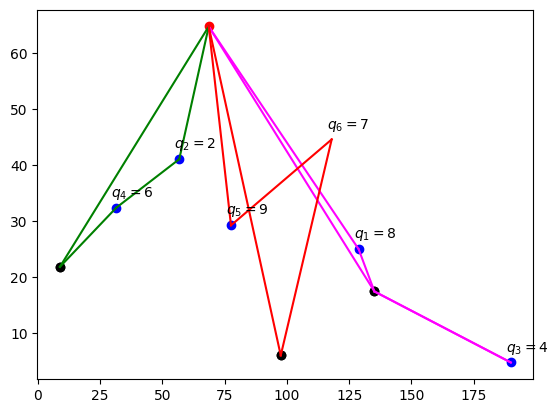

In [35]:
active_arcs = [a for a in A if x[a].x > 0.99]

# print(active_arcs)
plt.scatter(xc[1:n], yc[1:n], c = 'b')
plt.scatter(xc[n+2:],yc[n+2:], c= 'black')
plt.scatter(xc[0], yc[0], c='r')

# plt.title('Optimal route with %s as max weight'%C, fontsize = 20)
visited = []
for i in I:
    if(xc[i] not in visited):
      plt.annotate('$q_%d = %d$' % (i,q[i]), (xc[i]-2, yc[i]+2))
      visited.append(xc[i])
    # plt.annotate('$q_%d = %d$' % (i,y[i]), (xc[i]-5, yc[i]+5))
# import random

# number_of_vehicles=0
col=0
# print(type(active_arcs))
for i,j,k in active_arcs:
    if(i==0):
        rec(i,j,k,col)
        col+=1
plt.show()
# print(number_of_vehicles)